
Overall Scorecard:
On-time rate (%): 95.17
Cancel rate (%): 1.57
Orders with OOS (%): 16.77
Orders with substitution (%): 12.81
Complaint rate (%): 1.59
AOV fulfilled ($): 23.11
Median D2R (min): 2.48
P90 D2R (min): 8.85
Median CLAT (min): 1.92
P90 CLAT (min): 13.18

Store Scorecard (Top):
       STORE  orders  on_time_rate  cancel_rate   oos_rate   sub_rate  \
0  DashMart1    9018     94.522067     1.119982   0.853848   0.421379   
1   Grocery1    2736     97.258772     2.375731  53.728070  41.885965   
2   Grocery2    1143     94.575678     3.149606  49.168854  37.882765   
3   Grocery3     188     99.468085     1.595745  45.212766  31.382979   

   complaint_rate        aov  
0        1.020182  18.241765  
1        3.106725  33.398026  
2        2.712161  34.156938  
3        0.000000  32.630851  


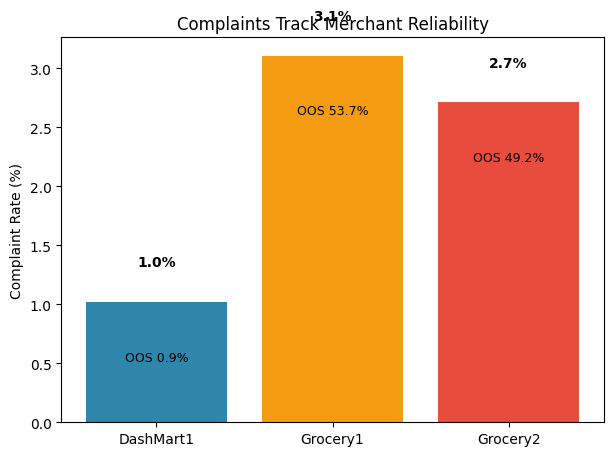

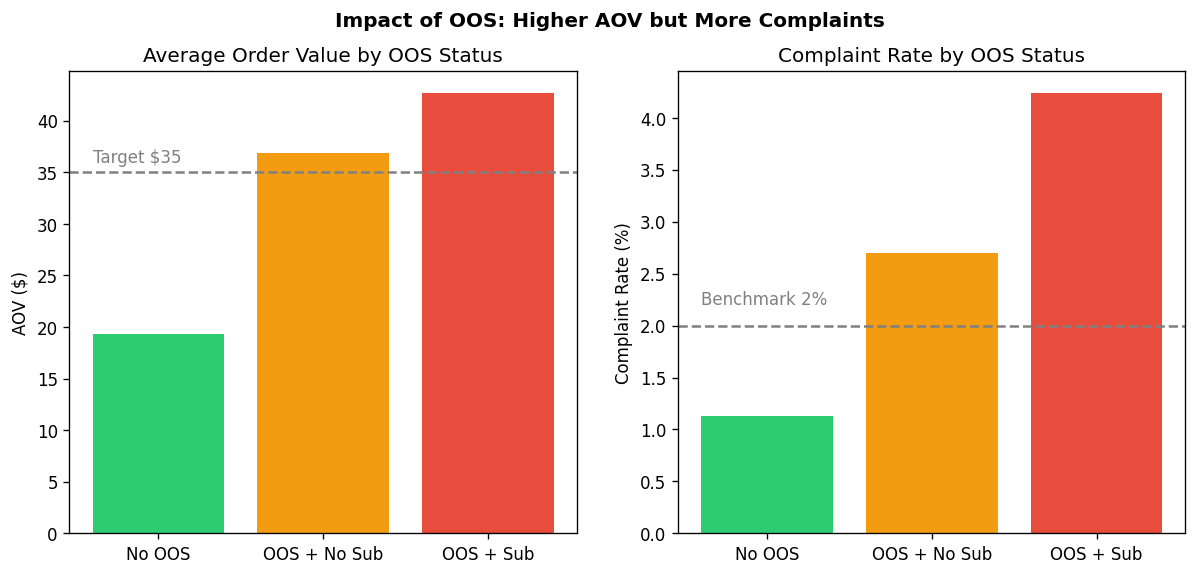

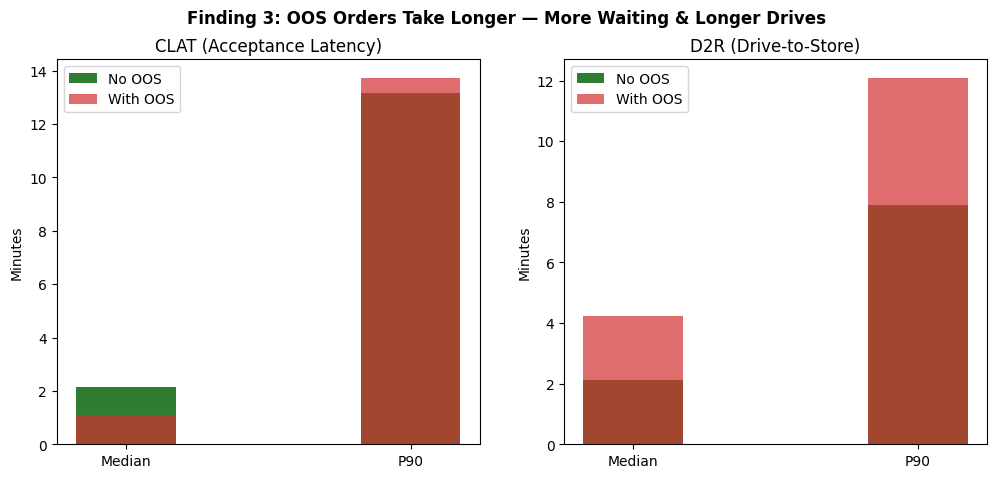


== Consumer KPIs ==
{'On-time rate (%)': np.float64(95.17004203286206), 'Cancel rate (%)': np.float64(1.5666794038975929), 'Orders with OOS (%)': np.float64(16.767290790982038), 'Orders with substitution (%)': np.float64(12.80855941918227), 'Complaint rate (%)': np.float64(1.5896064195643866), 'AOV fulfilled ($)': np.float64(23.11305434782609), 'Median D2R (min)': 2.483333, 'P90 D2R (min)': np.float64(8.85), 'Median CLAT (min)': 1.916667, 'P90 CLAT (min)': np.float64(13.183333)}

== Store Scorecard ==
       STORE  orders  on_time_rate  cancel_rate   oos_rate   sub_rate  \
0  DashMart1    9018     94.522067     1.119982   0.853848   0.421379   
1   Grocery1    2736     97.258772     2.375731  53.728070  41.885965   
2   Grocery2    1143     94.575678     3.149606  49.168854  37.882765   
3   Grocery3     188     99.468085     1.595745  45.212766  31.382979   

   complaint_rate        aov  
0        1.020182  18.241765  
1        3.106725  33.398026  
2        2.712161  34.156938  
3 

In [3]:
# -*- coding: utf-8 -*-
"""
DoorDash New Verticals Analysis
Author: Rohan Adusumilli
Date: Sept 2025

This notebook analyzes DoorDash delivery data to uncover the impact of Out-of-Stocks (OOS)
on customers, merchants, and Dashers.

Structure:
1. Load & clean data
2. Build order-level dataset
3. Compute KPIs and scorecards
4. Visualize consumer, merchant, and dasher experience
5. Findings → used in strategy doc
"""

# -------------------------------
# 1. Imports & Load Data
# -------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset (skip first header row if needed)
df = pd.read_csv("DD Assignment - Dataset.csv", header=1)

# -------------------------------
# 2. Data Cleaning
# -------------------------------
# Convert timestamps
df['DELIV_CREATED_AT']   = pd.to_datetime(df['DELIV_CREATED_AT'], errors='coerce', utc=True)
df['DELIV_CANCELLED_AT'] = pd.to_datetime(df['DELIV_CANCELLED_AT'], errors='coerce', utc=True)

# Convert dasher IDs (nullable integer)
df['DELIV_DASHER_ID'] = df['DELIV_DASHER_ID'].astype('Int64')

# Normalize boolean columns
bool_cols = [
    'DELIV_IS_20_MIN_LATE','DELIV_MISSING_INCORRECT_REPORT',
    'WAS_REQUESTED','WAS_MISSING','WAS_SUBBED','WAS_FOUND'
]
for c in bool_cols:
    df[c] = df[c].astype(bool)

# -------------------------------
# 3. Build Order-Level Dataset
# -------------------------------
order_df = (
    df.groupby('DELIVERY_UUID')
      .agg(
          CREATED_AT=('DELIV_CREATED_AT','first'),
          STORE=('DELIV_STORE_NAME','first'),
          SUBMARKET=('DELIV_SUBMARKET','first'),
          DASHER_ID=('DELIV_DASHER_ID','first'),
          CANCELLED=('DELIV_CANCELLED_AT', lambda x: x.notna().any()),
          LATE=('DELIV_IS_20_MIN_LATE','max'),
          CLAT=('DELIV_CLAT','first'),
          D2R=('DELIV_D2R','first'),
          COMPLAINT=('DELIV_MISSING_INCORRECT_REPORT','max'),
          AOV=('ITEM_PRICE','sum'),
          OOS_any=('WAS_MISSING','max'),
          SUB_any=('WAS_SUBBED','max')
      )
      .reset_index()
)

# -------------------------------
# 4. KPIs (Overall Scorecard)
# -------------------------------
kpis = {
    "On-time rate (%)": 100 * (1 - order_df['LATE'].mean()),
    "Cancel rate (%)": 100 * order_df['CANCELLED'].mean(),
    "Orders with OOS (%)": 100 * order_df['OOS_any'].mean(),
    "Orders with substitution (%)": 100 * order_df['SUB_any'].mean(),
    "Complaint rate (%)": 100 * order_df['COMPLAINT'].mean(),
    "AOV fulfilled ($)": order_df.loc[~order_df['CANCELLED'],'AOV'].mean(),
    "Median D2R (min)": order_df['D2R'].median(),
    "P90 D2R (min)": order_df['D2R'].quantile(0.9),
    "Median CLAT (min)": order_df['CLAT'].median(),
    "P90 CLAT (min)": order_df['CLAT'].quantile(0.9),
}
print("\nOverall Scorecard:")
for k,v in kpis.items():
    print(f"{k}: {v:.2f}")

# -------------------------------
# 5. Store Scorecard
# -------------------------------
store_scorecard = (
    order_df.groupby('STORE', as_index=False)
    .agg(
        orders=('DELIVERY_UUID','count'),
        on_time_rate=('LATE', lambda s: 100*(1 - s.mean())),
        cancel_rate=('CANCELLED', lambda s: 100*s.mean()),
        oos_rate=('OOS_any', lambda s: 100*s.mean()),
        sub_rate=('SUB_any', lambda s: 100*s.mean()),
        complaint_rate=('COMPLAINT', lambda s: 100*s.mean()),
        aov=('AOV','mean')
    )
    .sort_values('orders', ascending=False)
)
print("\nStore Scorecard (Top):")
print(store_scorecard.head())

# -------------------------------
# 6. Key Visualizations
# -------------------------------

# 6a. Complaints vs OOS (store-level)
subset = store_scorecard[store_scorecard['STORE'].isin(["DashMart1","Grocery1","Grocery2"])]
plt.figure(figsize=(7,5))
bars = plt.bar(subset['STORE'], subset['complaint_rate'], color=['#2E86AB','#F39C12','#E74C3C'])
plt.ylabel("Complaint Rate (%)")
plt.title("Complaints Track Merchant Reliability")
for i, bar in enumerate(bars):
    comp = subset['complaint_rate'].iloc[i]
    oos  = subset['oos_rate'].iloc[i]
    plt.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.3, f"{comp:.1f}%", ha='center', weight='bold')
    plt.text(bar.get_x()+bar.get_width()/2, bar.get_height()-0.5, f"OOS {oos:.1f}%", ha='center', fontsize=9)
plt.show()

# 6b. AOV & complaints by OOS/substitution
def oos_bucket(row):
    if not row['OOS_any']:
        return 'No OOS'
    if row['OOS_any'] and not row['SUB_any']:
        return 'OOS + No Sub'
    return 'OOS + Sub'
order_df['OOS_status'] = order_df.apply(oos_bucket, axis=1)

summary = (
    order_df.groupby('OOS_status')
    .agg(avg_aov=('AOV','mean'), complaint_rate=('COMPLAINT', lambda s: 100*s.mean()))
    .reset_index()
)

fig, axes = plt.subplots(1,2,figsize=(12,5), dpi=120)
# AOV
axes[0].bar(summary['OOS_status'], summary['avg_aov'], color=['#2ECC71','#F39C12','#E74C3C'])
axes[0].axhline(35, ls='--', color='gray'); axes[0].text(-0.4,36,"Target $35",color='gray')
axes[0].set_title("Average Order Value by OOS Status"); axes[0].set_ylabel("AOV ($)")
# Complaints
axes[1].bar(summary['OOS_status'], summary['complaint_rate'], color=['#2ECC71','#F39C12','#E74C3C'])
axes[1].axhline(2, ls='--', color='gray'); axes[1].text(-0.4,2.2,"Benchmark 2%",color='gray')
axes[1].set_title("Complaint Rate by OOS Status"); axes[1].set_ylabel("Complaint Rate (%)")
plt.suptitle("Impact of OOS: Higher AOV but More Complaints", weight='bold')
plt.show()

# 6c. Dasher friction (CLAT & D2R vs OOS)
def pcts(series): return {"p50":series.median(),"p90":series.quantile(0.9)}
no_oos, with_oos = order_df[~order_df['OOS_any']], order_df[order_df['OOS_any']]
clat_no, clat_yes = pcts(no_oos['CLAT']), pcts(with_oos['CLAT'])
d2r_no, d2r_yes   = pcts(no_oos['D2R']),  pcts(with_oos['D2R'])

fig, axes = plt.subplots(1,2,figsize=(12,5))
for ax,metric,no,yes in [(axes[0],"CLAT (Acceptance Latency)",clat_no,clat_yes),
                         (axes[1],"D2R (Drive-to-Store)",d2r_no,d2r_yes)]:
    bars=ax.bar(["Median","P90"],[no['p50'],no['p90']],width=0.35,label="No OOS",color="#2E7D32")
    bars=ax.bar(["Median","P90"],[yes['p50'],yes['p90']],width=0.35,label="With OOS",color="#D32F2F",alpha=0.7)
    ax.set_title(metric); ax.set_ylabel("Minutes"); ax.legend()
plt.suptitle("Finding 3: OOS Orders Take Longer — More Waiting & Longer Drives",weight='bold')
plt.show()

# -------------------------------
# 7. Appendix / Output Tables
# -------------------------------
print("\n== Consumer KPIs ==")
print(kpis)
print("\n== Store Scorecard ==")
print(store_scorecard.head(10))
print("\n== OOS Summary ==")
print(summary)